In [10]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('D:\\hw_data\\churn_prediction_data\\train.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,551,15806307,Trevisano,720,Spain,Male,38,5,114051.97,2,0,1,107577.29,0
1,6897,15709621,Martin,682,France,Female,54,4,62397.41,1,1,0,113088.60,1
2,4588,15619340,Palmer,672,France,Female,31,5,119903.67,1,1,1,132925.17,0
3,291,15620746,Napolitani,592,Spain,Female,40,4,104257.86,1,1,0,110857.33,0
4,1673,15646372,Yao,753,Spain,Male,42,5,120387.73,1,0,1,126378.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,5345,15584532,Yu,568,France,Female,35,6,121079.60,2,1,1,124890.50,1
7996,5837,15606641,Liao,602,Germany,Female,45,7,145846.07,1,1,0,99276.02,0
7997,7335,15739692,Ferri,679,Spain,Female,43,5,132810.01,1,1,0,130780.85,1
7998,9552,15791373,Worsnop,715,France,Male,38,4,118729.45,1,0,0,95484.52,0


In [11]:
def cretate(data_f, the_f_list, feature_list, features_list):
    the_data = data_f
    l = len(the_f_list)
    for i in range(l):
        the_data = the_data[the_data[feature_list[i]] == the_f_list[i]]
    length = len(the_data)
    if(length == 0):
        ans_list = [[the_f_list, length, "N/A", "N/A"]]
    else:
        ans_list = [[the_f_list, length, len(the_data[the_data["Exited"] == 0])/length
                     , len(the_data[the_data["Exited"] == 1])/length]]        
    if(len(the_f_list) < len(feature_list)):
        for feature in features_list[l]:
            ans_list += cretate(data_f,the_f_list + [feature] , feature_list, features_list)
    return ans_list

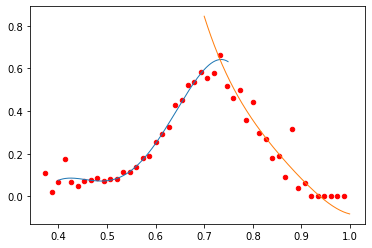

In [12]:
data_list = cretate(data, [], ["Age"], [list(range(28,76))])
data_list[0][0] = ["total"]
x = pd.DataFrame(data_list, columns = ["Catergories", "number", "ratio of not exit", "ratio of exit"])
x = x[x["number"] > 0]
x = x.iloc[1:48]
#這是原始的退出機率散佈圖(針對年齡)
plt.scatter(np.array(list(range(28,75)))/75,x["ratio of exit"],s=20, color = "red")
##二次回歸的準備
from scipy.optimize import curve_fit
def sigmoid(x, Beta_1, Beta_2, Beta_3, Beta_4, Beta_5):
    y = Beta_1 + Beta_2*x + Beta_3*x*x+ Beta_4*x*x*x + Beta_5*x*x*x*x
    return y
#這是28至55歲顧客的退出機率的二次回歸
x = np.array(data["Age"][data["Age"] <= 55])
y = np.array(data["Exited"][data["Age"] <= 55])
X = x/75
popt, pcov = curve_fit(sigmoid, X, y)
x = np.array(list(range(400,750)))/1000
plt.plot(x ,sigmoid(x, *popt) , linewidth=1, label='fit')
#這是55至75歲顧客的退出機率二次回歸
x2 = np.array(data["Age"][data["Age"] >= 55])
y2 = np.array(data["Exited"][data["Age"] >= 55])
X2 = x2/75
popt2, pcov2 = curve_fit(sigmoid, X2, y2)
x = np.array(list(range(700,1000)))/1000
plt.plot(x ,sigmoid(x, *popt2) , linewidth=1, label='fit')
y = np.array(data["Exited"])
del data["Exited"]

In [13]:
from xgboost import XGBClassifier
del data["CustomerId"]
del data["Surname"]
del data["RowNumber"]
Age = np.array(data["Age"])
result1 = sigmoid(Age/75, *popt)
result1[Age > 55] = 0
result2 = sigmoid(Age/75, *popt2)
result2[Age <= 55] = 0
result = result2 + result1
feature = ['Geography',"Gender",'NumOfProducts']
data["Ages"] = result
del data["Age"]
del data["Tenure"]
data["CreditScore"] = data["CreditScore"]/1000
data["EstimatedSalary"] = data["EstimatedSalary"]/200000
data["Balance"] = data["Balance"]/200000
data["ratio"] = data["Balance"]/data["EstimatedSalary"]
data = pd.get_dummies(data, columns = feature)
X = np.array(data)

In [14]:
xgbc = XGBClassifier(base_score=0.1,max_depth = 10, max_delta_step = 1)
xgbc.fit(X, y)

c:\users\myful\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.1, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=1, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
predict = xgbc.predict(X)
answer = y + 0
test = (predict + answer - 1)**2
print(test.mean(),predict)
print(sum(predict * answer)/sum(predict))
print(sum(predict * answer)/sum(answer))
print(predict.mean())
print(answer.mean())

0.999625 [0 1 0 ... 1 0 0]
1.0
0.9981617647058824
0.203625
0.204


In [16]:
data = pd.read_csv('D:\\hw_data\\churn_prediction_data\\test.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,2209,15623595,Scott,726,France,Female,39,3,62397.41,1,0,0,106139.31
1,9924,15740283,Yegorova,661,France,Male,42,3,130339.64,1,1,0,125776.38
2,4617,15802368,Tan,545,France,Male,34,6,62397.41,2,1,1,78372.28
3,6077,15615322,Anayochukwu,731,Spain,Female,42,3,86717.08,1,1,0,136026.27
4,9240,15766374,Glover,533,France,Female,50,6,62397.41,1,1,1,135205.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7872,15617348,Taylor,628,France,Male,35,6,62397.41,2,1,1,96201.09
1996,4257,15642785,Tokareva,639,Germany,Male,41,5,98154.30,2,1,0,109531.64
1997,2273,15766575,Trevisan,548,France,Female,46,3,119078.34,2,1,1,116725.67
1998,315,15610271,Dickson,602,Spain,Female,44,7,62397.41,2,1,1,128135.95


In [17]:
del data["CustomerId"]
del data["Surname"]
del data["RowNumber"]
Age = np.array(data["Age"])
result1 = sigmoid(Age/75, *popt)
result1[Age > 55] = 0
result2 = sigmoid(Age/75, *popt2)
result2[Age <= 55] = 0
result = result2 + result1
feature = ['Geography',"Gender",'NumOfProducts']
data["Ages"] = result
del data["Age"]
del data["Tenure"]
data["CreditScore"] = data["CreditScore"]/1000
data["EstimatedSalary"] = data["EstimatedSalary"]/200000
data["Balance"] = data["Balance"]/200000
data["ratio"] = data["Balance"]/data["EstimatedSalary"]
data = pd.get_dummies(data, columns = feature)
X = np.array(data)

In [18]:
data = pd.read_csv('D:\\hw_data\\churn_prediction_data\\test.csv')
predict = xgbc.predict(X)
print(predict.mean())
data["predict"] = predict
Exited = data["predict"]
RowNumber = data["RowNumber"]
upload = np.array([RowNumber,Exited])
upload = upload.transpose()
upload = list(upload)
upload
x = pd.DataFrame(upload, columns = ["RowNumber", "Exited"])
x.to_csv('4th_try.csv')

0.1605
